In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,r2_score,accuracy_score

In [74]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
y = df_train['label'].values
x = df_train.drop(columns='label').values
y = torch.from_numpy(y)
y = nn.functional.one_hot(y,10)
x = x/255.0
df_test = df_test/255.0

In [75]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,paths):
        self.dataset_df = pd.read_csv(paths)
        self.y = self.dataset_df['label'].values
        self.x = self.dataset_df.drop(columns='label').values
        self.x = self.x/255.0
        self.y = nn.functional.one_hot(torch.from_numpy(self.y),10)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,index):
        img = x[index].copy()
        img = img.reshape(1,28,28) 
        return img,y[index]

In [76]:
dataset = dataset('./train.csv')
dataset_size = len(dataset)
train_size = int(0.7*dataset_size)
test_size = dataset_size-train_size

In [77]:
train_dataset ,test_dataset = random_split(dataset,[train_size,test_size])
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=64)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=64)

In [88]:
class model(nn.Module):
    def __init__(self):
        super(model,self).__init__()
        self.models = nn.Sequential(
        nn.Conv2d(1,32,3,1,0),
        nn.LeakyReLU(0.05,True),
        nn.Dropout2d(0.3),

        nn.Conv2d(32,64,3,1,0),
        nn.LeakyReLU(0.05,True),
        nn.Dropout2d(0.2),

        nn.Conv2d(64,128,3,1,0),
        nn.LeakyReLU(0.05,True),
        nn.Dropout2d(0.2),

        nn.MaxPool2d(2),
        nn.Conv2d(128,128,3,1,0),
        nn.LeakyReLU(0.05,True),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(2),
        
        nn.Flatten(1),
        nn.Linear(2048,1024),
        nn.LeakyReLU(0.05,True),
        nn.Dropout(0.4),
        nn.Linear(1024,2048),
        nn.LeakyReLU(0.05,True),
        nn.Dropout(0.1),

        nn.Linear(2048,4096),
        nn.LeakyReLU(0.05,True),
        nn.Dropout(0.3),
        nn.Linear(4096,10),
    )
    def forward(self,x):
        return self.models(x)

In [89]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mode = model().to(device)
mode.double()
optimizer = optim.AdamW(mode.parameters(),lr=0.0002,betas=(0.9,0.999),weight_decay=0.00002)
criterion = nn.CrossEntropyLoss()

In [91]:
mode.train()
for epoch in range(0,20):
    sum_loss = 0.0
    count = 0
    for i,data in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
        img,label = data[0].to(device),data[1].to(device)
        output = mode(img)
        class_indices = label.nonzero().squeeze()
        losses = criterion(output.float(),label.float())
        losses.backward()
        optimizer.step()
        sum_loss += losses.item()
        if count%((train_size//64)//3)==0:
            print(f"Epoch [{epoch}/{count}] Loss:{sum_loss/count}")
    print(f"Epoch {epoch} Loss:{sum_loss/count}")
        
         

Epoch [0/153] Loss:0.019722361316002017
Epoch [0/306] Loss:0.02058335253234106
Epoch [0/459] Loss:0.020327426008912478
Epoch 0 Loss:0.02029400882277949
Epoch [1/153] Loss:0.013719953920586062
Epoch [1/306] Loss:0.018282160665608792
Epoch [1/459] Loss:0.020501779318349775
Epoch 1 Loss:0.02064808549100986
Epoch [2/153] Loss:0.01629171914167457
Epoch [2/306] Loss:0.019907023461676433
Epoch [2/459] Loss:0.019634437220680444
Epoch 2 Loss:0.019696526098706944
Epoch [3/153] Loss:0.013892642632354598
Epoch [3/306] Loss:0.01493524087291557
Epoch [3/459] Loss:0.015608766888139468
Epoch 3 Loss:0.015575422374071047
Epoch [4/153] Loss:0.010562107328487579
Epoch [4/306] Loss:0.01344163453179991
Epoch [4/459] Loss:0.014887843586781373
Epoch 4 Loss:0.01485549796483729
Epoch [5/153] Loss:0.014045359603175647
Epoch [5/306] Loss:0.016286467876080065
Epoch [5/459] Loss:0.017080319384714052
Epoch 5 Loss:0.017228538179377844
Epoch [6/153] Loss:0.014077704915894025
Epoch [6/306] Loss:0.01746929211593275
Epoc

In [92]:
mode.eval()

predict = []
true_label = []
for i,data in enumerate(test_loader):
    data,label = data[0].to(device),data[1].to(device)
    with torch.no_grad():
        output = mode(data)
    class_indices = label.nonzero().squeeze()
    _,output = torch.max(output,1)

    for i,j in zip(output,class_indices):
        predict.append(i.item())
        true_label.append(j[1].item())

In [95]:
r2 = round(r2_score(true_label , predict),10)*100
accuracy = accuracy_score(true_label, predict)
print(f'R2 : {r2}')
print(f'Acc: {accuracy}')

R2 : 97.47484473
Acc: 0.9895246409015157


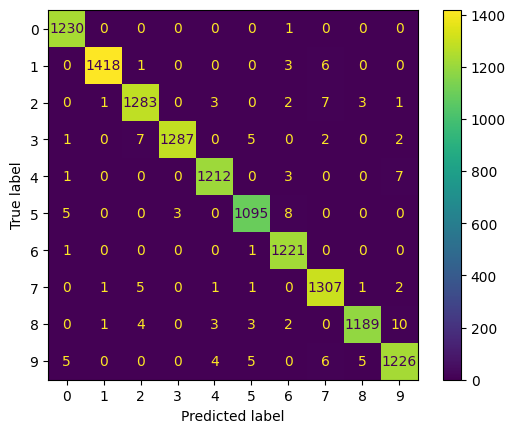

In [86]:
cm = confusion_matrix(true_label,predict)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()